In [1]:
pip install earthengine-api geemap

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import ee
ee.Authenticate()
ee.Initialize(project='cnn-topography')


Successfully saved authorization token.


# Dataset Creation Using Python + Google Earth Engine (GEE)

In [7]:
import ee
import geemap
import os
import requests
from shapely.geometry import shape

In [8]:
# Initialize Earth Engine
ee.Initialize(project='cnn-topography')

# Define location of interest (downtown Chicago)

# Set up the parameters
tile_size_m = 512 # tile size in meters
city_bounds = ee.Geometry.Rectangle([-87.84, 41.64, -87.52, 42.02])
start_date = '2023-06-01'
end_date = '2023-08-31'

# Choose the Sentinel-2 RGB image with least cloud coverage
image = (ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
         .filterBounds(city_bounds)
         .filterDate(start_date, end_date)
         .sort("CLOUD_COVER")
         .first()
         .select(['B4', 'B3', 'B2']))

# Define a function to create a grid of tile regions
def create_grid(bbox, tile_size):
  coords = bbox.coordinates().get(0).getInfo()
  lon_min, lat_min = coords[0]
  lon_max, lat_max = coords[2]

  # Convert using EPSG:4326 approximations
  step_lon = tile_size / 85390.0
  step_lat = tile_size / 111320.0

  # lon_min += step_lon / 2
  # lon_max -= step_lon / 2
  # lat_min += step_lat / 2
  # lat_max -= step_lat / 2

  lons = int((lon_max - lon_min) / step_lon)
  lats = int((lat_max - lat_min) / step_lat)

  grid = []
  for i in range(lons):
    for j in range(lats):
      lon = lon_min + i * step_lon
      lat = lat_min + j * step_lat
      center = ee.Geometry.Point([lon, lat])
      tile = center.buffer(tile_size / 2).bounds()
      grid.append(tile)
  return grid

# Create the grid
tiles = create_grid(city_bounds, tile_size_m)

# Filter out the tiles that are within city_boounds
safe_tiles = []
for tile in tiles:
  if city_bounds.contains(tile, ee.ErrorMargin(1)).getInfo():
    safe_tiles.append(tile)

# Download folder
output_dir = 'sentinel_tiles'
os.makedirs(output_dir, exist_ok=True)

# Download loop
for i, tile in enumerate(safe_tiles):
  file_name = f'chicago_tile_{i}.tif'
  file_path = os.path.join(output_dir, file_name)
  
  if os.path.exists(file_path):
    print(f"Skipping {file_name}, already downloaded.")
    continue
  
  try:
    print(f"Requesting tile {i}...")
    url = image.clip(tile).getDownloadURL({
      'scale': 10,
      'region': tile.getInfo()['coordinates'],
      'format': 'geotiff'
    })
    
    
    response = requests.get(url, stream=True)
    with open(file_path, 'wb') as f:
      for chunk in response.iter_content(chunk_size=8192):
        f.write(chunk)
    
    print(f"Saved: {file_name} ({i+1}/{len(safe_tiles)})")
  except Exception as e:
    print(f"Failed on tile {i}: {e}")
    break

Requesting tile 0...
Saved: chicago_tile_0.tif (1/4212)
Requesting tile 1...
Saved: chicago_tile_1.tif (2/4212)
Requesting tile 2...
Saved: chicago_tile_2.tif (3/4212)
Requesting tile 3...
Saved: chicago_tile_3.tif (4/4212)
Requesting tile 4...
Saved: chicago_tile_4.tif (5/4212)
Requesting tile 5...
Saved: chicago_tile_5.tif (6/4212)
Requesting tile 6...
Saved: chicago_tile_6.tif (7/4212)
Requesting tile 7...
Saved: chicago_tile_7.tif (8/4212)
Requesting tile 8...
Saved: chicago_tile_8.tif (9/4212)
Requesting tile 9...
Saved: chicago_tile_9.tif (10/4212)
Requesting tile 10...
Saved: chicago_tile_10.tif (11/4212)
Requesting tile 11...
Saved: chicago_tile_11.tif (12/4212)
Requesting tile 12...
Saved: chicago_tile_12.tif (13/4212)
Requesting tile 13...
Saved: chicago_tile_13.tif (14/4212)
Requesting tile 14...
Saved: chicago_tile_14.tif (15/4212)
Requesting tile 15...
Saved: chicago_tile_15.tif (16/4212)
Requesting tile 16...
Saved: chicago_tile_16.tif (17/4212)
Requesting tile 17...
Save

In [9]:
pip install osmnx geopandas shapely

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Automated Labeling with OpenStreetMap (OSM)

In [10]:
import osmnx as ox
import geopandas as gpd
from shapely.geometry import box

## Access OSM Datasets

In [11]:
# Define bounding box
bbox = (-87.84, 41.64, -87.52, 42.02)

In [12]:
# We will access two datasets, one for the landuse and one for amenities

# Typology (landuse polygons)
landuse = ox.features.features_from_bbox(
    bbox=bbox,
    tags={'landuse': True}
    )

# Amenities and geatures
amenities = ox.features.features_from_bbox(
    bbox=bbox,
    tags={
    'leisure': True,
    'amenity': True,
    'tourism': True,
    'natural': True
})

## Convert Tiles to GeoDataFrame

In [13]:
from shapely.geometry import shape
import geopandas as gpd
import pandas as pd
from shapely.ops import unary_union

In [15]:
ee.Initialize(project='cnn-topography')

In [16]:
# Convert safe_tiles to GeoJSON followed by Shapely geometries
tile_data = []
for i, tile in enumerate(safe_tiles):
  # Convert Earth Engine geometry to GeoJSON dict
  geom_geojson = tile.getInfo()
  geom_shape = shape(geom_geojson)
  tile_data.append({'tile_id': i, 'geometry': geom_shape})

# Create a GeoDataFrame of GeoJSON tiles
tiles_gdf = gpd.GeoDataFrame(tile_data, crs="EPSG:4326")

In [17]:
# Ensure matching coordinate reference systems
landuse = landuse.to_crs(tiles_gdf.crs)

# Assign dominant landuse (typology) to each tile
def get_typology(tile):
    intersected = landuse[landuse.intersects(tile.geometry)]
    if intersected.empty:
        return 'unknown'
    return intersected['landuse'].value_counts().idxmax()

tiles_gdf['typology'] = tiles_gdf.apply(get_typology, axis=1)
tiles_gdf["tile_id"] = tiles_gdf["tile_id"].apply(lambda x: f"chicago_tile_{x}")

In [18]:
# Ensure CRS matches
amenities = amenities.to_crs(tiles_gdf.crs)

tile_union = tiles_gdf.unary_union
filtered_amenities = amenities[amenities.intersects(tile_union)]

# Check for presence of each amenity category
def check_amenity(tile, key):
    return not amenities[amenities[key].notna() & amenities.intersects(tile.geometry)].empty

tiles_gdf['has_park'] = tiles_gdf.apply(lambda row: check_amenity(row, 'leisure'), axis=1)
tiles_gdf['has_school'] = tiles_gdf.apply(lambda row: check_amenity(row, 'amenity'), axis=1)
tiles_gdf['has_museum'] = tiles_gdf.apply(lambda row: check_amenity(row, 'tourism'), axis=1)
tiles_gdf['has_water'] = tiles_gdf.apply(lambda row: check_amenity(row, 'natural'), axis=1)

In [19]:
tiles_gdf.head()

cols = ['tile_id', 'typology', 'has_park', 'has_school', 'has_museum', 'has_water']
tiles_gdf[cols].to_csv("tile_labels.csv", index=False)

In [20]:
# Check tiles_gdf for expected columns
tiles_gdf[['tile_id', 'typology', 'has_park', 'has_school', 'has_museum', 'has_water']].head()

,tile_id,typology,has_park,has_school,has_museum,has_water
0,chicago_tile_0,residential,True,False,False,True
1,chicago_tile_1,residential,True,True,False,True
2,chicago_tile_2,residential,False,False,False,True
3,chicago_tile_3,residential,True,False,False,True
4,chicago_tile_4,residential,False,False,False,True


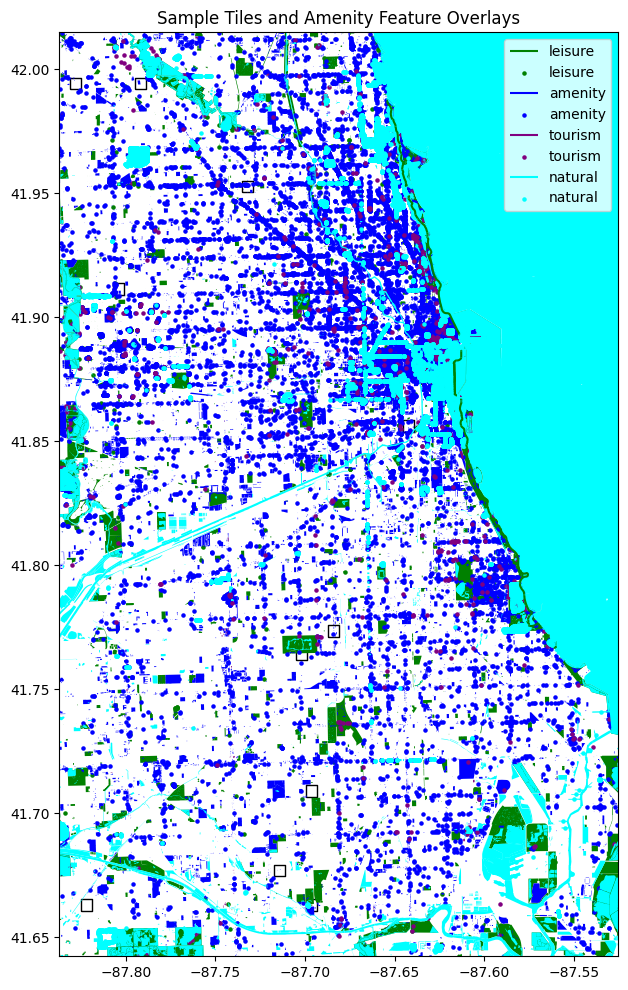

In [21]:
import matplotlib.pyplot as plt

# Select a small sample for plotting
sample_tiles = tiles_gdf.sample(12, random_state=42)

from shapely.ops import unary_union

# Plot amenity-labeled tiles with overlay
fig, ax = plt.subplots(figsize=(12, 12))
sample_tiles.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1)

# Overlay each amenity type with a different color
colors = {'leisure': 'green', 'amenity': 'blue', 'tourism': 'purple', 'natural': 'aqua'}
for tag, color in colors.items():
  filtered_amenities[filtered_amenities[tag].notna()].plot(ax=ax, color=color, markersize=5, label=tag)

plt.legend()
plt.title("Sample Tiles and Amenity Feature Overlays")
xmin, ymin, xmax, ymax = tiles_gdf.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
plt.show()

fig.savefig("tile_overlay_filtered.png", dpi=300, bbox_inches='tight')

# Convolutional Neural Network Setup (PyTorch)

## Dataset Loader

In [35]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
import rasterio

class SentinelTileDataset(Dataset):
    def __init__(self, label_csv, image_dir, transform=None):
        self.labels = pd.read_csv(label_csv)
        self.image_dir = image_dir
        self.transform = transform
        
        # Map the typology labels to class indices
        self.typology_classes = sorted(self.labels["typology"].unique())
        self.typology_to_idx = {label: idx for idx, label in enumerate(self.typology_classes)}
        self.crop_size = (48, 48)
        
    def __len__(self):
        return len(self.labels)
        
    def __getitem__(self, idx):
        # Helper function to center crop the tensor
        def center_crop_tensor(tensor, size=(48, 48)):
            _, h, w = tensor.shape
            crop_h, crop_w = size
            top = (h - crop_h) // 2
            left = (w - crop_w) // 2
            return tensor[:, top:top + crop_h, left:left + crop_w]
        
        
        row = self.labels.iloc[idx]
        tile_id = row["tile_id"]
        image_path = os.path.join(self.image_dir, f"{tile_id}.tif")
            
        # Load and normalize the images
        with rasterio.open(image_path) as src:
            img = src.read([1, 2, 3]).astype("float32")
            img /= 3000.0 # Normalize to [0, 1] range
            
        img_tensor = torch.tensor(img)
            
        # Resize images for consistent input shape
        img_tensor = center_crop_tensor(img_tensor)
            
        # Prepare the labels
        typology_idx = self.typology_to_idx[row["typology"]]
        amenities = torch.tensor([
            row["has_park"],
            row["has_school"],
            row["has_museum"],
            row["has_water"]
        ], dtype=torch.float32)
            
        return img_tensor, typology_idx, amenities

## Create Train/Validation Split & Load Data

In [36]:
from torch.utils.data import DataLoader, random_split

dataset = SentinelTileDataset(
    label_csv="tile_labels.csv",
    image_dir="sentinel_tiles/"
)

# Split the dataset 80/20 into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [37]:
img, typ, amenities = dataset[0]
print("Image shape:", img.shape)
print("Typology index:", typ)
print("Amenities:", amenities)

Image shape: torch.Size([3, 48, 48])
Typology index: 17
Amenities: tensor([1., 0., 0., 1.])


## Define the Custom CNN

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [39]:
class UrbanCNN(nn.Module):
    def __init__(self, num_typology_classes, num_amenities=4):
        super(UrbanCNN, self).__init__()
        
        # Shared feature extractor
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        
        # Global feature output size estimation (based on 53x53 input)
        self.flat_dim = 64 * 6 * 6 # This is based on 3 pooling layers (53 -> 26 -> 13 -> 6)
        
        # Typology classification head
        self.typ_fc1 = nn.Linear(self.flat_dim, 128)
        self.typ_out = nn.Linear(128, num_typology_classes)
        
        # Amenity multi-label head
        self.amen_fc1 = nn.Linear(self.flat_dim, 128)
        self.amen_out = nn.Linear(128, num_amenities)
        
    def forward(self, x):
        # Feature extraction
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)
        
        x = x.view(-1, self.flat_dim)
        
        # Typology output
        typ = F.relu(self.typ_fc1(x))
        typ = self.typ_out(typ)
        
        # Amenity output
        amen = F.relu(self.amen_fc1(x))
        amen = self.amen_out(amen)
        
        return typ, amen

In [40]:
# Read class count from the dataset
num_classes = len(dataset.typology_classes)

model = UrbanCNN(num_typology_classes=num_classes)
print(model)

UrbanCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (typ_fc1): Linear(in_features=2304, out_features=128, bias=True)
  (typ_out): Linear(in_features=128, out_features=20, bias=True)
  (amen_fc1): Linear(in_features=2304, out_features=128, bias=True)
  (amen_out): Linear(in_features=128, out_features=4, bias=True)
)


## Model Training

### Define Initial Parameters

In [41]:
import torch.optim as optim

# Assign the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss functions and optimizer
typology_loss_fn = nn.CrossEntropyLoss()
amenity_loss_fn = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

### Training Loop

In [42]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    
    for imgs, typologies, amenities in train_loader:
        imgs = imgs.to(device)
        typologies = typologies.to(device)
        amenities = amenities.to(device)
        
        optimizer.zero_grad()
        out_typ, out_amen = model(imgs)
        
        loss_typ = typology_loss_fn(out_typ, typologies)
        loss_amen = amenity_loss_fn(out_amen, amenities)
        
        loss = loss_typ + loss_amen
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    
    # Calculate average loss for the epoch
    avg_train_loss = train_loss / len(train_loader)
    
    # Validation Loop
    model.eval()
    val_loss = 0
    correct_typ = 0
    total_typ = 0
    
    with torch.no_grad():
        for imgs, typologies, amenities in val_loader:
            imgs = imgs.to(device)
            typologies = typologies.to(device)
            amenities = amenities.to(device)
            
            out_typ, out_amen = model(imgs)
            
            val_loss += (
                typology_loss_fn(out_typ, typologies) +
                amenity_loss_fn(out_amen, amenities)
            )
            
            preds_typ = torch.argmax(out_typ, dim=1)
            correct_typ += (preds_typ == typologies).sum().item()
            total_typ += typologies.size(0)
            
    # Calculate average validation loss and accuracy
    avg_val_loss = val_loss / len(val_loader)
    val_acc = correct_typ / total_typ
    
    print(f"Epoch {epoch+1}/{num_epochs} "
          f"Train Loss: {avg_train_loss:.4f} "
          f"Validation Loss: {avg_val_loss:.4f} "
          f"Validation Typology Accuracy: {val_acc:.4f}")

Epoch 1/10 Train Loss: 2.3060 Validation Loss: 1.9132 Validation Typology Accuracy: 0.5374
Epoch 2/10 Train Loss: 1.8710 Validation Loss: 1.8912 Validation Typology Accuracy: 0.5350
Epoch 3/10 Train Loss: 1.8150 Validation Loss: 1.8709 Validation Typology Accuracy: 0.5374
Epoch 4/10 Train Loss: 1.8055 Validation Loss: 1.8673 Validation Typology Accuracy: 0.5338
Epoch 5/10 Train Loss: 1.8186 Validation Loss: 1.8424 Validation Typology Accuracy: 0.5374
Epoch 6/10 Train Loss: 1.7736 Validation Loss: 1.8318 Validation Typology Accuracy: 0.5540
Epoch 7/10 Train Loss: 1.7733 Validation Loss: 1.8009 Validation Typology Accuracy: 0.5552
Epoch 8/10 Train Loss: 1.7303 Validation Loss: 1.9056 Validation Typology Accuracy: 0.5184
Epoch 9/10 Train Loss: 1.7467 Validation Loss: 1.7681 Validation Typology Accuracy: 0.5552
Epoch 10/10 Train Loss: 1.7149 Validation Loss: 1.7666 Validation Typology Accuracy: 0.5563


In [43]:
# Save the trained model
torch.save(model.state_dict(), "urban_cnn_model.pth")

## Model Evaluation

### Typology Evaluation

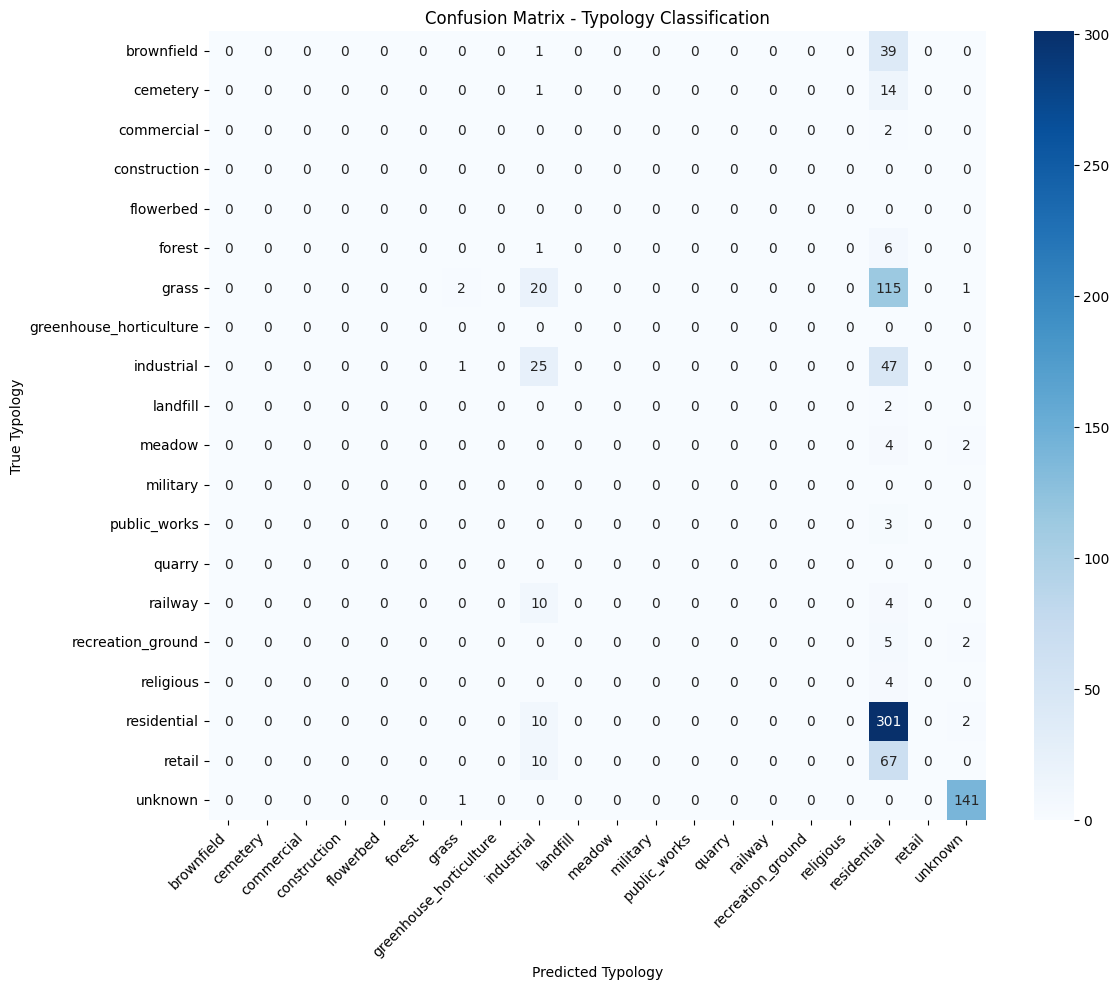


Classification Report (Typology):
                         precision    recall  f1-score   support

             brownfield       0.00      0.00      0.00        40
               cemetery       0.00      0.00      0.00        15
             commercial       0.00      0.00      0.00         2
           construction       0.00      0.00      0.00         0
              flowerbed       0.00      0.00      0.00         0
                 forest       0.00      0.00      0.00         7
                  grass       0.50      0.01      0.03       138
greenhouse_horticulture       0.00      0.00      0.00         0
             industrial       0.32      0.34      0.33        73
               landfill       0.00      0.00      0.00         2
                 meadow       0.00      0.00      0.00         6
               military       0.00      0.00      0.00         0
           public_works       0.00      0.00      0.00         3
                 quarry       0.00      0.00      0.00

In [46]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Evaluate the model
model.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for imgs, typologies, _ in val_loader:
        imgs = imgs.to(device)
        outputs, _ = model(imgs)
        preds = torch.argmax(outputs, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(typologies.cpu().numpy())
        
# Ensure consistent label order
all_class_indices = sorted(dataset.typology_to_idx.values())
idx_to_typ = {idx: label for label, idx in dataset.typology_to_idx.items()}
label_names = [idx_to_typ[i] for i in all_class_indices]

# Generate a confusion matrix
cm = confusion_matrix(all_targets, all_preds, labels=all_class_indices)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
             xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted Typology")
plt.ylabel("True Typology")
plt.title("Confusion Matrix - Typology Classification")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("confusion_matrix_typology.png", dpi=300)
plt.show()

# Classification report
print("\nClassification Report (Typology):")
print(classification_report(all_targets,
                            all_preds,
                            labels=all_class_indices,
                            target_names=label_names,
                            zero_division=0))

### Amenity Evaluation

In [47]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import torch.nn.functional as F

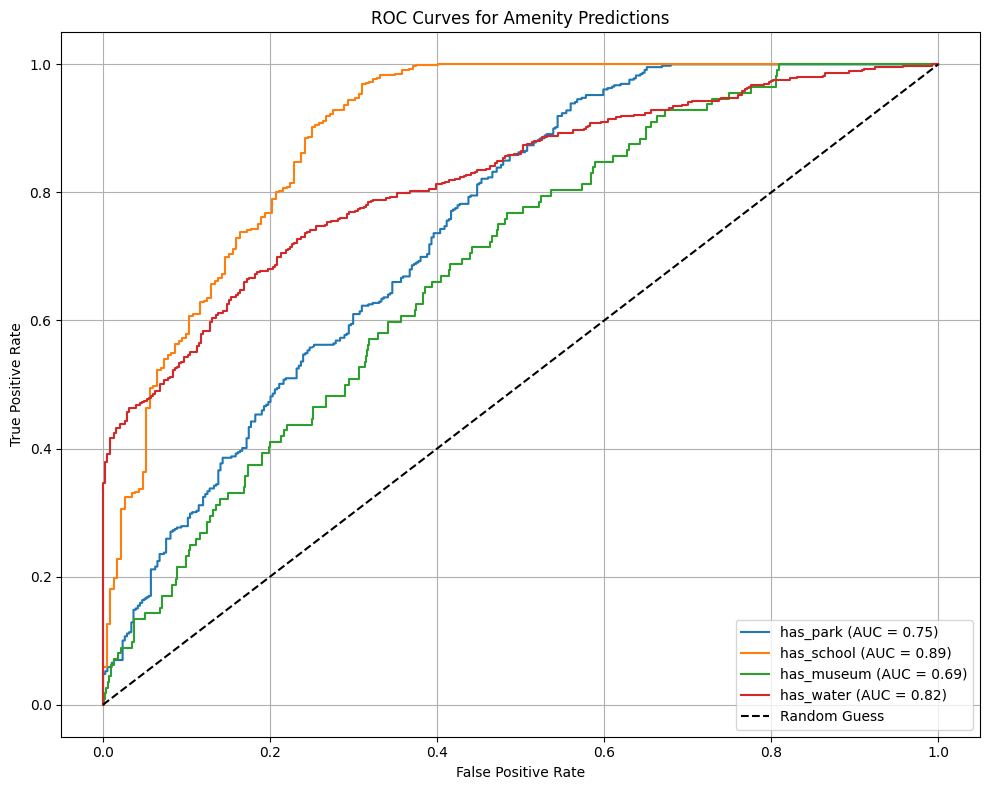

In [48]:
# Evaluate the model
model.eval()

amenity_preds = []
amenity_targets = []

with torch.no_grad():
    for imgs, _, amenities in val_loader:
        imgs = imgs.to(device)
        amenities = amenities.to(device)
        
        _, amen_logits = model(imgs)
        probs = torch.sigmoid(amen_logits)
        
        amenity_preds.append(probs.cpu())
        amenity_targets.append(amenities.cpu())
        
# Stack all predictions and targets
y_scores = torch.cat(amenity_preds).numpy()
y_true = torch.cat(amenity_targets).numpy()

# Amenity label names
amenity_names = ["has_park", "has_school", "has_museum", "has_water"]

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i, name in enumerate(amenity_names):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
    
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.title("ROC Curves for Amenity Predictions")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_curves_amenities.png", dpi=300)
plt.show()